# A10-3

## Peer-graded Assignment: A multi-resolution sinusoidal model

## Introduction

You have seen through several assignments that the choice of window size is an important tradeoff between time and frequency resolution. Longer windows have a better frequency resolution and can resolve two close sinusoids even at low frequencies, while smaller windows have a better time resolution leading to sharper onsets. So far, in all the analyses, we have only considered a single window length over the whole sound. As we know, analysis of signals with low frequency components needs a longer window as compared to signals with high frequency content. The optimal choice of window length is thus dependent on the frequency content of the signal. In other words, it is better to choose a longer window for analysis at low frequencies while a shorter window is sufficient at higher frequency. In this assignment, you will explore the use of multiple window sizes for analysis in different frequency bands of the signals.


## Guidelines

You will implement a multi-resolution sine model compared to the one in sineModel.sineModel() function in sms-tools (sine model version without tracking). For each audio frame (at each ’pin’) you will compute three different DFTs with three different window sizes (which are input param- eters). You then compute the sinusoid peaks for each of the DFTs. Given three frequency bands spanning the whole range of 0-22050 Hz, you will then choose the peaks from these three DFTs depending on the band to which the frequency of the peak belongs, low frequency peaks from the DFT computed on a larger window.

e.g. Given three frequency bands B1: 0 <= f < 1000Hz, B2: 1000 <= f < 5000, B3: 5000 <= f < 22050, and three window sizes M1 = 4095, M2 = 2047, M3 = 1023, we generate three windows w1, w2, w3 with sizes M1, M2, M3 respectively. For every frame of audio x1 = x[pin-hM1:pin+hM2], we compute three DFTs X1 = dftAnal(x1, w1, N1), X2 = dftAnal(x2, w2, N2) and X3 = dftAnal(x3, w3, N3). Choose N1, N2 and N3 as needed. We then compute the peaks of the magnitude spectrum in each case and interpolate them. For reconstruction, we choose the peaks computed from X1, X2, X3 for reconstruction in frequency bands B1, B2 and B3, respectively. With peaks thus chosen, we reconstruct the frame. This ensures that we have a longer analysis window at low frequencies and a shorter analysis window at high frequencies.

Modify sineModel.sineModel() in sineModel.py (make a copy before changing the code) so that it can take three windows with different sizes, three FFT sizes, and band edges as in- put parameters, e.g., sineModel.sineModelMultiRes(x, fs, [w1, w2, w3], [N1, N2, N3], t, [B1, B2, B3]). Implement the multi-resolution analysis as described above.

Choose two different real world polyphonic recordings from freesound.org that have both a relevant melodic and percussion components. An example could be orchestra.wav in the sounds folder of sms-tools. Visualize each sound and choose a suitable set of parameters for its analysis. Experiment with different window lengths and band edges for the two sounds such that you get both crisp onsets and good frequency resolution.

You will be mainly evaluated for your efforts in the code you write and the contents of the report. You will evaluate a minimum of three other peers in this assignment.

### Part 1
Write a short report (1 page) with the freesound.org links to the sound used, mentioning the band edges and the window sizes you used for each sound. Write a short explanation to justify your choices.

In the report, comment upon the advantage (or the lack of it) of using such a multi-resolution analysis in terms of obtaining better time-frequency resolution, computational complexity and extending the technique to HPR and HPS models. Specifically, if you were to improve the multi- resolution analysis and extend it to HPR and HPS model, comment on the challenges you would face for sinusoid tracking and F0 estimation. Additionally, you can suggest further methods to improving the time-frequency resolution trade-off (optional).
Make sure your report contains the following:

• Freesound link to the two sounds chosen.
• Explanation and justification of the band edges and the window sizes for each sound.
• Observations about the advantages of a multi-resolution analysis (comment on the time-
frequency resolution, computational complexity and extensions to HPR and HPS models).
• Challenges you might face if you were to extend it to HPR and HPS models (mainly in sinusoid tracking and F0 estimation).
• (Optional) Further methods to improving the time-frequency resolution trade-off. Upload the report as a PDF with this question.

In [15]:
import numpy as np
from scipy.signal import blackmanharris, triang
from scipy.fftpack import ifft, fftshift
import math
import sys, os
sys.path.append('../../software/models/')
import dftModel as DFT
import utilFunctions as UF
import stft
from scipy import signal

import sineModel as SM
import matplotlib.pyplot as plt

def sineModelMultiResAnal(x, fs, ws, Ns, Bs, H, t,
                            minSineDur=0.02, maxnSines=150, freqDevOffset=10, freqDevSlope=0.001):
    """
    Analysis/synthesis of a sound using the multi sinusoidal model, with sine tracking
    x: input array sound, ws: analysis windows, Ns: size of complex spectrums, t: threshold in negative dB , Bs: band edges
    returns xtfreq, xtmag, xtphase: frequencies, magnitudes and phases of sinusoidal tracks
    """
    hsN = H/2
    pend = x.size
    pin = max([hsN] + [int(math.floor((w.size+1)/2)) for w in ws])
    x = np.append(np.zeros(pin),x)
    x = np.append(x,np.zeros(pin))

    def dftAnal(p, w, N, B):
        hM1 = int(math.floor((w.size+1)/2))
        hM2 = int(math.floor(w.size/2))
        x1 = x[p-hM1:p+hM2]
        fftbuffer = np.zeros(N)
        rw = w / sum(w)
        mX, pX = DFT.dftAnal(x1, rw, N)

        upperIndex = Bs.index(B)
        lower_bin = 1
        if upperIndex > 0:
            lower_bin = int(np.ceil(float(Bs[upperIndex-1]) * N / fs))
        upper_bin = int(np.ceil(float(B) * N / fs))

        ploc = UF.peakDetection(mX, t)
        # choose the peaks in band
        ploc = ploc[np.logical_and(ploc>lower_bin, ploc<=upper_bin)]
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)
        ipfreq = fs*iploc/float(N)

        return (ipfreq, ipmag, ipphase)

    xtfreq = np.array([])
    xtmag = np.array([])
    xtphase = np.array([])
    tfreq = np.array([])
    while pin<=pend:
        #-----analysis-----
        pfs = np.array([])
        pms = np.array([])
        pps = np.array([])

        for i, w in enumerate(ws):
            pf, pm, pp = dftAnal(pin, w, Ns[i], Bs[i])
            pfs = np.concatenate((pfs, pf))
            pms = np.concatenate((pms, pm))
            pps = np.concatenate((pps, pp))

        tfreq, tmag, tphase = SM.sineTracking(pfs, pms, pps, tfreq, freqDevOffset, freqDevSlope)
        tfreq = np.resize(tfreq, min(maxnSines, tfreq.size))
        tmag = np.resize(tmag, min(maxnSines, tmag.size))
        tphase = np.resize(tphase, min(maxnSines, tphase.size))
        jtfreq = np.zeros(maxnSines)
        jtmag = np.zeros(maxnSines)
        jtphase = np.zeros(maxnSines)
        jtfreq[:tfreq.size]=tfreq
        jtmag[:tmag.size]=tmag
        jtphase[:tphase.size]=tphase

        if xtfreq.size == 0:
            xtfreq = jtfreq
            xtmag = jtmag
            xtphase = jtphase
        else:
            xtfreq = np.vstack((xtfreq, jtfreq))
            xtmag = np.vstack((xtmag, jtmag))
            xtphase = np.vstack((xtphase, jtphase))

        pin += H

    xtfreq = SM.cleaningSineTracks(xtfreq, round(fs*minSineDur/H))
    return xtfreq, xtmag, xtphase

def sineModelMultiRes(inputFile, windows, Ns, Bs,
                    t=-80, minSineDur=0.02,
                    maxnSines=150, freqDevOffset=10, freqDevSlope=0.001, drawGraph=True):

    sN = 512
    H = sN/4
    (fs, x) = UF.wavread(inputFile)

    tfreq, tmag, tphase = sineModelMultiResAnal(x, fs, windows, Ns, Bs, H, t,
                            minSineDur, maxnSines, freqDevOffset, freqDevSlope)
    y = SM.sineModelSynth(tfreq, tmag, tphase, sN, H, fs)

    # calculate diff between x & y
    diffLength = min([x.size, y.size])
    diff = np.abs(x[:diffLength] - y[:diffLength])
    print("diff {0}".format(np.sum(diff)))

    outputFile = os.path.basename(inputFile)[:-4] + '_sineModelMulti.wav'
    UF.wavwrite(y, fs, outputFile)

    if not drawGraph:
        return

    # create figure to show plots
    plt.figure(figsize=(12, 9))

    # frequency range to plot
    maxplotfreq = 11000.0

    # plot the input sound
    plt.subplot(3,1,1)
    plt.plot(np.arange(x.size)/float(fs), x)
    plt.axis([0, x.size/float(fs), min(x), max(x)])
    plt.ylabel('amplitude')
    plt.xlabel('time (sec)')
    plt.title('input sound: x')

    # plot the sinusoidal frequencies
    plt.subplot(3,1,2)
    if (tfreq.shape[1] > 0):
        numFrames = tfreq.shape[0]
        frmTime = H*np.arange(numFrames)/float(fs)
        tfreq[tfreq<=0] = np.nan
        plt.plot(frmTime, tfreq)
        plt.axis([0, x.size/float(fs), 0, maxplotfreq])
        plt.title('frequencies of sinusoidal tracks')

    # plot the output sound
    plt.subplot(3,1,3)
    plt.plot(np.arange(y.size)/float(fs), y)
    plt.axis([0, y.size/float(fs), min(y), max(y)])
    plt.ylabel('amplitude')
    plt.xlabel('time (sec)')
    plt.title('output sound: y')

    plt.tight_layout()
    plt.show()

diff 5122.01340995


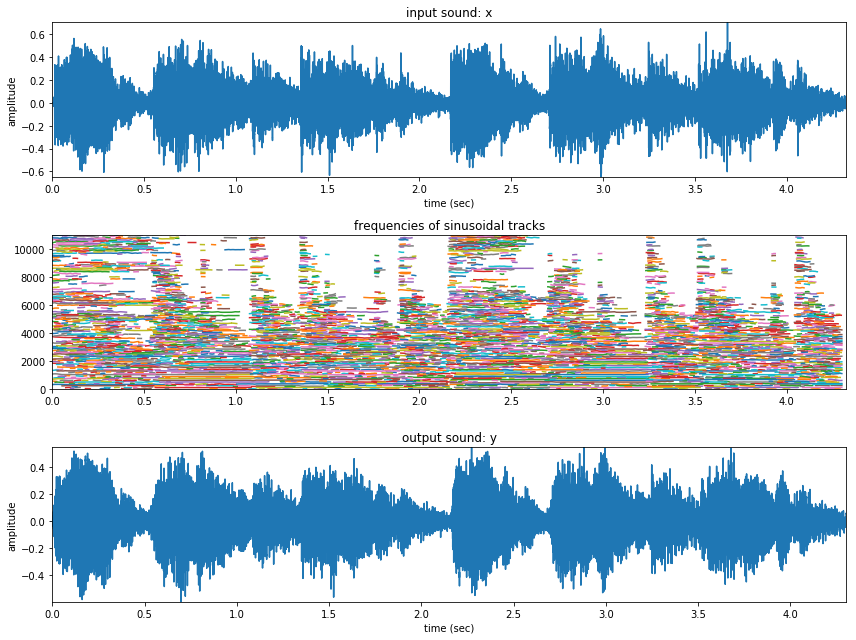

In [34]:
inputFile="../../sounds/A10_3_src/330955__lawrier__mono_copy_toam_oriental_touch_orchestra.wav"
W1, W2, W3 = (2048, 2048, 2048)
w = [signal.blackman(W1), signal.blackman(W2), np.blackman(W3)]
N1, N2, N3 = (4096, 4096, 2048)
N = [N1, N2, N3]
f1, f2, f3 = 2000, 4300, 22050
B = [f1, f2, f3]

sineModelMultiRes(inputFile=inputFile,windows=w,Ns=N,Bs=B)

diff 4484.97245639


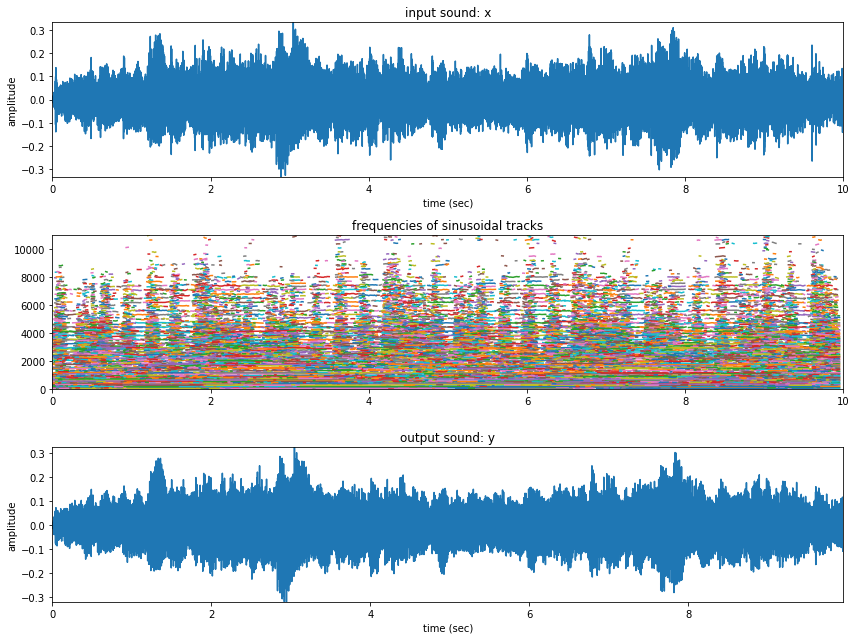

In [38]:
inputFile="../../sounds/A10_3_src/331071__dshoot85__sounds_of_j-simple_orchestra-mono.wav"
W1, W2, W3 = (4096, 3011, 2048)
w = [signal.blackman(W1), signal.blackman(W2), np.blackman(W3)]
N1, N2, N3 = (4096, 4096, 2048)
N = [N1, N2, N3]
f1, f2, f3 = 1000, 5000, 22050
B = [f1, f2, f3]

sineModelMultiRes(inputFile=inputFile,windows=w,Ns=N,Bs=B)

(1). Links:
- Traditional orchestra: https://freesound.org/people/LawrieR/sounds/330955/
- Western orchestra: https://freesound.org/people/dshoot85/sounds/331071/
Both sound files include melody and percussion contents.

